# Gaussian Processes

skorch supports integration with the fantastic [GPyTorch](https://gpytorch.ai/) library. GPyTorch implements various Gaussian Process (GP) techniques on top of PyTorch.

GPyTorch adopts many patterns from PyTorch, thus making it easy to pick up for seasoned PyTorch users. Similarly, the skorch GPyTorch integration should look familiar to seasoned skorch users. However, GPs are a different beast than the more common, non-probabilistic machine learning techniques. It is important to understand the basic concepts before using them in practice.

This notebook is not the place to learn about GPs in general, instead a basic understanding is assumed. If you're looking for an introduction to probabilistic programming and GPs, here are some pointers:

- The GPyTorch [documentation](https://docs.gpytorch.ai/en/stable/)
- The book [Gaussian Processes for Machine Learning](http://gaussianprocess.org/gpml/chapters/) by Carl Edward Rasmussen and Christopher K. I. Williams
- The lecture series [Probabilistic Machine Learning](https://www.youtube.com/playlist?list=PL05umP7R6ij1tHaOFY96m5uX3J21a6yNd) by Philipp Hennig

Below, we will show you how to use skorch for Gaussian Processes through GPyTorch. We assume that you are familiar with how skorch and PyTorch work and we will focus on how using GPs differs from using non-probabilistic deep learning techniques with skorch. For a discussion on when and when not to use GPyTorch with skorch, please have a look at our [documentation](https://skorch.readthedocs.io/en/latest/user/probabilistic.html).

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Gaussian_Processes.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Gaussian_Processes.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

If you haven't already, you should install GPyTorch, since it is not installed automatically after installing skorch:

```bash
# using pip
pip install -U gpytorch
# using conda
conda install gpytorch -c gpytorch
```

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch', 'gpytorch'])
except ImportError:
    pass

## Table of contents

* [Exact Gaussian Process Regression](#Exact-Gaussian-Process-Regression)
  * [Simple example: sine curve](#Simple-example:-sine-curve)
  * [GP regression with real world data](#Regression-with-real-world-data)
* [Stochastic Variational GP Regression](#Stochastic-Variational-GP-Regression)
* [Classification](#Classification)
  * [Binary classification](#Binary-classification)
  * [Multiclass classification](#Multiclass-Classification)

## Imports

In [ ]:
import math
import os
import urllib.request

In [ ]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
plt.style.use('seaborn')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

# Exact Gaussian Process Regression

GPyTorch implmenets different methods to solve GPs. The most basic form is to use exact solutions. Variational GPs are described further below.

## Simple example: sine curve

The "Hello world" of GPs is predicting a sine curve with Gaussian noise added on top. We will start with this example.

### Creating the data

First we synthesize our data. For training, we use a sine curve with Gaussian noise added on top. For validation, we just use the sine without noise, assuming this is the underlying ground truth. To make it difficult for the model, the training data will only contain very few data points for now.

In [ ]:
sampling_frequency = 0.5
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + torch.randn(len(X_train)) * 0.2

In [ ]:
X_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(X_valid)

As you can see below, there is a slight hint of periodicity in the training data but it could also just be noise.

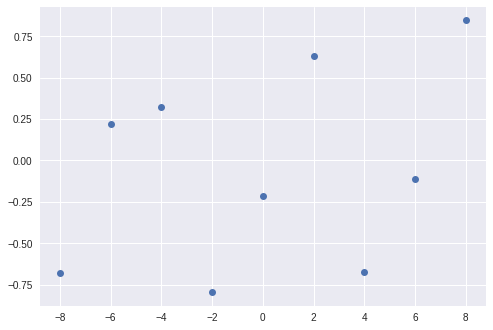

In [ ]:
plt.plot(X_train, y_train, 'o')

### Defining the module

As usual with PyTorch, the core of your modeling approach is to define the module. In our case, instead of subclassing `torch.nn.Module`, we subclass `gpytorch.models.ExactGP` (which itself is a subclass of `torch.nn.Module`), since we want to do exact GP. As always, we need to define our own `__init__` method (don't forget to call `super().__init__`) and our own `forward` method.

In [ ]:
class RbfModule(gpytorch.models.ExactGP):
    def __init__(self, likelihood, noise_init=None):
        # detail: We don't set train_inputs and train_targets here because skorch
        # will take care of that.
        super().__init__(train_inputs=None, train_targets=None, likelihood=likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Again, we don't want to go into too much details about GPs or GPyTorch. The important ingredients here are the _mean function_ and the _kernel function_. As the name suggests, the mean function is only there to determine the means of the Gaussian distribution. The kernel function is used to calculate the covariance matrix of the data points. Together, the means and covariance matrix are sufficient to define a Gaussian distribution.

For the mean function `gpytorch.means.ConstantMean` will often do. Choosing the correct kernel, however, is where it gets interesting. This kernel should be chosen wisely so as to fit the problem as best as possible. The correct choice here is as crucial as choosing the correct Deep Learning architecture &mdash; when you choose an RNN for an image classification problem, you will have little luck. That being said, a good start is often to use the `RBFKernel` and then iterate from there. That's why we use the RBF for our toy example.

The output of the `forward` method should always be a `gpytorch.distributions.MultivariateNormal` for `ExactGP`. It represents the prior latent distribution conditioned on the input data. The posterior is computed by applying a likelihood, which is `gpytorch.likelihoods.GaussianLikelihood` by default for GP regression.

### skorch `ExactGPRegressor`

Now let's define our skorch model. For this, we import `ExactGPRegressor` and initialize it in much the same way as we would a `NeuralNet`.

In [ ]:
from skorch.probabilistic import ExactGPRegressor

In [ ]:
gpr = ExactGPRegressor(
    RbfModule,
    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    device=DEVICE,
    batch_size=-1,
)

As you can see, we pass the `RbfModule` defined above as the first argument, as we always do. We also define the optimizer, learning rate (`lr`) and device as usual. We could pass our own `likelihood` argument, but since we use the default likelihood, we don't need to do that.

One oddity you might have noticed is `batch_size=-1`. -1 is a placeholder that means: take all the data at once, don't use batching. The reason for this is that the exact solution requires all data to be passed at the same time, it does not work on batches. The batch size is -1 by default but we set it here explicitly to make it clear that it is so.

If you need to use batches (say, you don't have enough GPU memory to fit all your data), you can use variational GPs, as shown later in the notebook.

<div class="alert alert-block alert-info">
    <b>Info:</b>
    GPyTorch stores a reference to the training data (i.e X and y) on the module. This can make your model quite big if your training data is large. However, exact GPs are typically not used with large datasets - if you want to avoid this issue, take a look at the variational method described further below.
</div>

### Sampling

At this point, we can already show a new feature that is available thanks to GPs. They allow us to sample from the underlying distribution, conditioned on our data, even though we have not even called `fit` on the model. To do this, we initialize the `ExactGPRegressor` by calling `initialize()` and then use the `sample` method. The first argument to `sample` is the data to condition on, in this case the training data, and the second argument is the number of samples to draw.

We plot the result next to the ground truth and the training data for comparison.

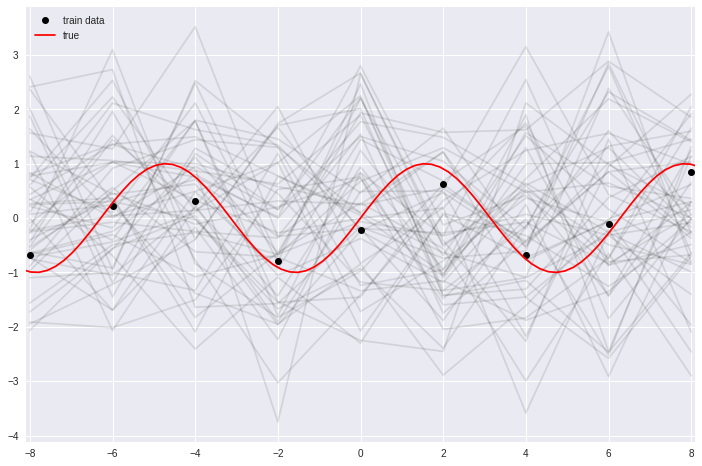

In [ ]:
gpr.initialize()

samples = gpr.sample(X_train, n_samples=50)
samples = samples.cpu().detach().numpy()  # turn into numpy array

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

It can often be wise to plot a couple of samples _before_ starting a lengthy training process. These samples can be compared to the underlying data to see if the chosen model looks reasonable _a priori_. If the distribution of the target looks very different from the sampled distribution, it means it could not result from the assumed distribution. No matter how well you train, your model will never fit your data. In such a case, you probably need to find a better kernel function.

### Fitting

As always, to train the model, we call the `fit` method and pass the training data and targets as arguments:

In [ ]:
gpr.fit(X_train, y_train)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2771  0.0091
      2        1.2650  0.0055
      3        1.2533  0.0063
      4        1.2416  0.0104
      5        1.2312  0.0081
      6        1.2211  0.0068
      7        1.2111  0.0058
      8        1.2017  0.0060
      9        1.1932  0.0072
     10        1.1850  0.0041
     11        1.1771  0.0064
     12        1.1698  0.0041
     13        1.1632  0.0103
     14        1.1570  0.0091
     15        1.1511  0.0057
     16        1.1456  0.0047
     17        1.1408  0.0049
     18        1.1363  0.0045
     19        1.1320  0.0051
     20        1.1281  0.0045


<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  ),
)

<div class="alert alert-block alert-info">
    <b>Info:</b>
    For GP regression, skorch does <i>not</i> perform a train/valid split by default. This is why you only see the train loss here, not the validation loss as usual. The reason for this decision is that a random split is most often not appropriate for GP regression. E.g. when you deal with a time series, random splitting would result in data leakage. Therefore, if you want validation scores, it is probably best to implement your own <code>train_split</code> or use <code>skorch.helper.predefined_split</code> if you already have split your data beforehand (see the example further below).
</div>

### Analyzing the trained model

Now that our model is trained, we can repeat the sampling process from above. As you can see, the samples fit the data much better now.

/usr/local/lib/python3.8/dist-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


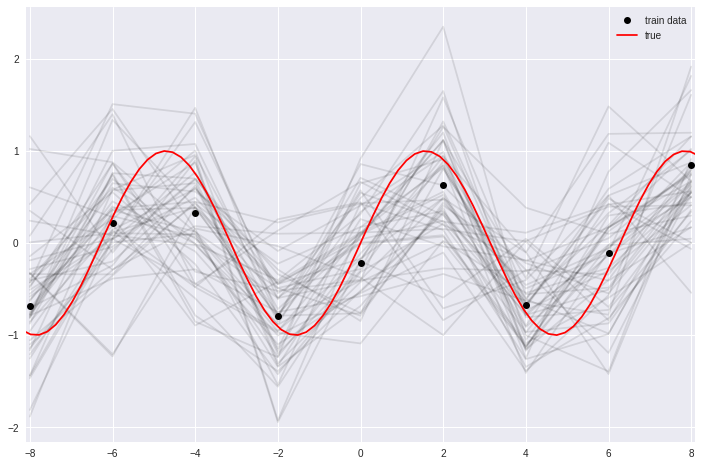

In [ ]:
samples = gpr.sample(X_train, 50)
samples = samples.detach().numpy()  # turn into numpy array

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

Since the model represents a probability distribution, instead of just making point predictions as is most often the case for Deep Learning, we can use the distribution to give us confidence intervals. To do this, we can pass `return_std=True` to the `predict` call. This will return one standard deviation for the given data, which we can add/subtract from our prediction to get upper/lower confidence bounds:

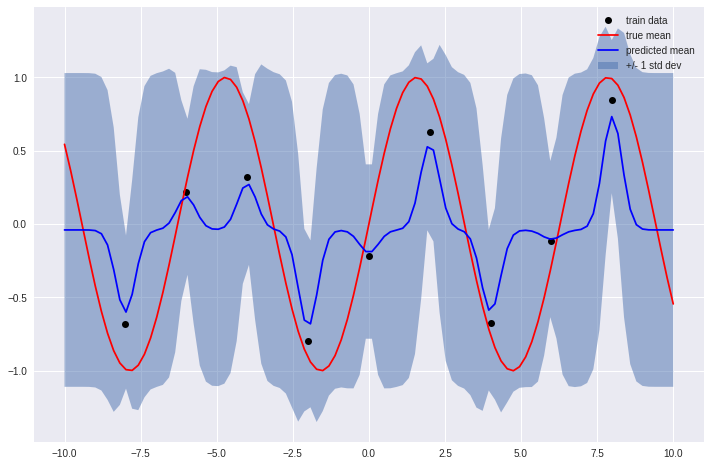

In [ ]:
y_pred, y_std = gpr.predict(X_valid, return_std=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true mean')
ax.plot(X_valid, y_pred, color='blue', label='predicted mean')
ax.fill_between(X_valid, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.legend()

As you can see, the confidence bounds are quite wide most of the time. Only at the training data points is the model more confident. This is exactly what we should expect: At the points where the model has seen some data, it is more confident, but between data points, it is less confident.

### More data

Below, we increase the sampling frequency from our sine function and train the same model again to show how a well fit model looks like.

In [ ]:
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + torch.randn(len(X_train)) * 0.2

In [ ]:
gpr = ExactGPRegressor(
    RbfModule,optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    batch_size=-1,
    device=DEVICE,
)
gpr.fit(X_train.reshape(-1, 1), y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        1.1546  0.0063
      2        1.1222  0.0080
      3        1.0879  0.0045
      4        1.0535  0.0071
      5        1.0188  0.0059
      6        0.9833  0.0076
      7        0.9474  0.0057
      8        0.9114  0.0046
      9        0.8754  0.0062
     10        0.8395  0.0041
     11        0.8038  0.0054
     12        0.7684  0.0044
     13        0.7337  0.0060
     14        0.7000  0.1071
     15        0.6673  0.0067
     16        0.6357  0.0069
     17        0.6054  0.0073
     18        0.5762  0.0049
     19        0.5479  0.0047
     20        0.5200  0.0060


<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  ),
)

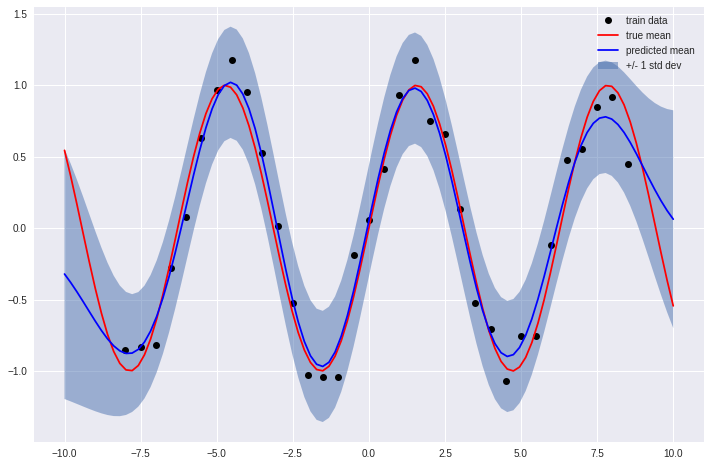

In [ ]:
y_pred, y_std = gpr.predict(X_valid, return_std=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true mean')
ax.plot(X_valid, y_pred, color='blue', label='predicted mean')
ax.fill_between(X_valid, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.legend()

Here we can see that the confidence intervals are much narrower than above, even between data points. This means that the model is quite confident in _interpolating_ between data points. Notice, however, that the confidence bounds increase considerably at the left and right end, i.e. at values outside of the range of the training data. This means that the model is less confident in _extrapolating_ which is typically a good thing.

### Confidence region

Another way skorch implements to quickly get the confidence interval is through the `confidence_region` method. This mirrors the method by the same name in GPyTorch. By default, it returns the lower and upper bound for 2 standard deviations, but this can be changed through the `sigmas` argument.

In [ ]:
lower, upper = gpr.confidence_region(X_valid, sigmas=2)

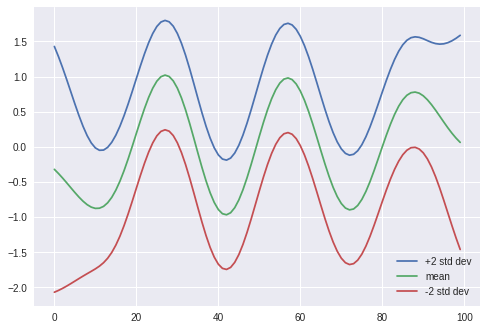

In [ ]:
plt.plot(upper, label='+2 std dev')
plt.plot(y_pred, label='mean')
plt.plot(lower, label='-2 std dev')
plt.legend();

### Grid search

As always, one of the advantages of using skorch is the sklearn integration. That means that we can plug our regressor into `GridSearchCV` et al. However, there is a caveat to this, as explained below. But first, let's set up the grid search.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

In [ ]:
gpr = ExactGPRegressor(
    RbfModule,
    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    batch_size=-1,
    device=DEVICE,
    
    train_split=False,
    verbose=0,
)

We turn off skorch-internal train/validation split, since the grid search already performs the data splitting for us. We also set the verbosity level to 0 to avoid too many print outputs.

In [ ]:
search = GridSearchCV(gpr, params, cv=3, scoring='neg_mean_squared_error', verbose=1)

Since we deal with a regression task, we choose an appropriate scoring function, in this case mean squared error. Now let's start the grid search to see the problem mentioned above:

In [ ]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=<class 'skorch.probabilistic.ExactGPRegressor'>[uninitialized](
  module=<class '__main__.RbfModule'>,
),
             param_grid={'lr': [0.01, 0.02], 'max_epochs': [10, 20]},
             scoring='neg_mean_squared_error', verbose=1)

The grid search finished successfully and we found the best hyper-parameters:

In [ ]:
search.best_score_

-0.5268993576367696

In [ ]:
search.best_params_

{'lr': 0.01, 'max_epochs': 20}

## Regression with real world data

So far, we have only worked with toy data. To show how to work with real world data, we will reproduce an example from the GPyTorch docs:

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Spectral_Delta_GP_Regression.html

This dataset contains the "BART ridership on the 5 most commonly traveled stations in San Francisco". "BART" is the "Bay Area Rapid Transit", i.e. public transit system in the San Francisco bay area.

For more details, please consult the link.

### Getting the data

First of all we need to download the data. This only needs to be done if the data has not already been downloaded.

In [ ]:
path = os.path.join('datasets', 'BART_sample.pt')
url = 'https://drive.google.com/uc?export=download&id=1A6LqCHPA5lHa5S3lMH8mLMNEgeku8lRG'
if not os.path.isfile(path):
    print('Downloading BART sample dataset...')
    urllib.request.urlretrieve(url, path)
    
train_x, train_y, test_x, test_y = torch.load(path, map_location=DEVICE)

We need to scale the input data a bit, following the tutorial:

In [ ]:
train_x_min = train_x.min()
train_x_max = train_x.max()

X_train = train_x - train_x_min
X_valid = test_x - train_x_min

The target data also needs to be scaled. However, contrary to the tutorial, we will use sklearn's `StandardScaler` for this. Although it performs the same transformation as in the tutorial, it allows us to easily inverse transform the targets back to their original scale, which will be useful later.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# We need to transpose here because the target data is sequence x sample
# but we want to scale over the samples, not over the sequence.
y_scaler = StandardScaler().fit(train_y.T)
y_train = torch.from_numpy(y_scaler.transform(train_y.T).T).float()
y_valid = torch.from_numpy(y_scaler.transform(test_y.T).T).float()

In [ ]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([5, 1440, 1]) torch.Size([5, 1440]) torch.Size([5, 240, 1]) torch.Size([5, 240])


### Defining the module

The module is effectively the same as in the tutorial.

In [ ]:
class SpectralDeltaGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood, num_deltas, noise_init=None):
        super(SpectralDeltaGP, self).__init__(X, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.SpectralDeltaKernel(
            num_dims=X.size(-1),
            num_deltas=num_deltas,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Defining the likelihood

Here we show an example of using a non default likelihood. We wrap the initialization of the likelihood inside a function because we want to use some specific methods, such as `register_prior`. This function can be passed as the `likelihood` parameter to `ExactGPRegressor`.

In [ ]:
def get_likelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-11),
        noise_prior=gpytorch.priors.HorseshoePrior(0.1),
        noise=1e-2,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=noise_constraint,
    )
    likelihood.register_prior("noise_prior", noise_prior, "noise")
    likelihood.noise = noise
    return likelihood

In [ ]:
gpr = ExactGPRegressor(
    SpectralDeltaGP,
    module__num_deltas=1500,
    module__X=X_train if DEVICE == 'cpu' else X_train.cuda(),
    module__y=y_train if DEVICE == 'cpu' else y_train.cuda(),

    likelihood=get_likelihood,

    optimizer=torch.optim.Adam,
    lr=2e-4,
    max_epochs=50,
    batch_size=-1,
    device=DEVICE,
)

Again, as explained above, we additionally need to pass `X` and `y` to the module and we need to set the batch size to -1, since we still deal with exact GPs.

### Training the model

In [ ]:
# This context manager ensures that we dont try to use Cholesky. This is
# in following with the tutorial.
with gpytorch.settings.max_cholesky_size(0):
    gpr.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.8028  2.2675
      2        2.1384  2.0103
      3        1.6900  2.0103
      4        1.4348  2.0003
      5        1.2347  1.9784
      6        1.1455  2.0053
      7        1.0804  1.9863
      8        1.0156  2.5769
      9        1.0041  1.9767
     10        0.9777  1.9827
     11        0.9485  1.9757
     12        0.8967  1.9726
     13        0.8376  1.9643
     14        0.8271  1.9682
     15        0.8202  1.9856
     16        0.7917  2.0139
     17        0.7529  2.0055
     18        0.7299  1.9974
     19        0.7212  2.3588
     20        0.7110  1.9645
     21        0.7031  1.9801
     22        0.6786  1.9879
     23        0.6624  1.9652
     24        0.6574  1.9974
     25        0.6463  1.9728
     26        0.6381  1.9961
     27        0.6352  1.9799
     28        0.6127  1.9715
     29        0.6076  2.0109
     30        0.5876  2.0330
     31        0.5829  1.9846
     32   

### Analyzing the trained model

Again, let's plot the predictions and the standard deviations for our 5 time series and see how well the model learned.

In [ ]:
%%time
y_pred, y_std = gpr.predict(X_valid, return_std=True)

CPU times: user 7.06 s, sys: 62 ms, total: 7.12 s
Wall time: 7.08 s


Here we make use of our [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the targets back to their original scale. Remember to also scale the standard deviations.

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred.T).T
y_std = y_scaler.inverse_transform(y_std.T).T

In [ ]:
def plot_bart(ax, X_train, y_train, X_valid, y_valid, y_pred, y_std):
    lower = y_pred - y_std
    upper = y_pred + y_std

    ax.plot(X_train, y_train, 'k*', label='train')
    ax.plot(X_valid, y_valid, 'r*', label='valid')
    # Plot predictive means as blue line
    ax.plot(X_valid, y_pred, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_valid, lower, upper, alpha=0.5, label='+/- 1 std dev')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_ylabel('Passenger Volume', fontsize=16)
    ax.set_xticks([])
    return ax

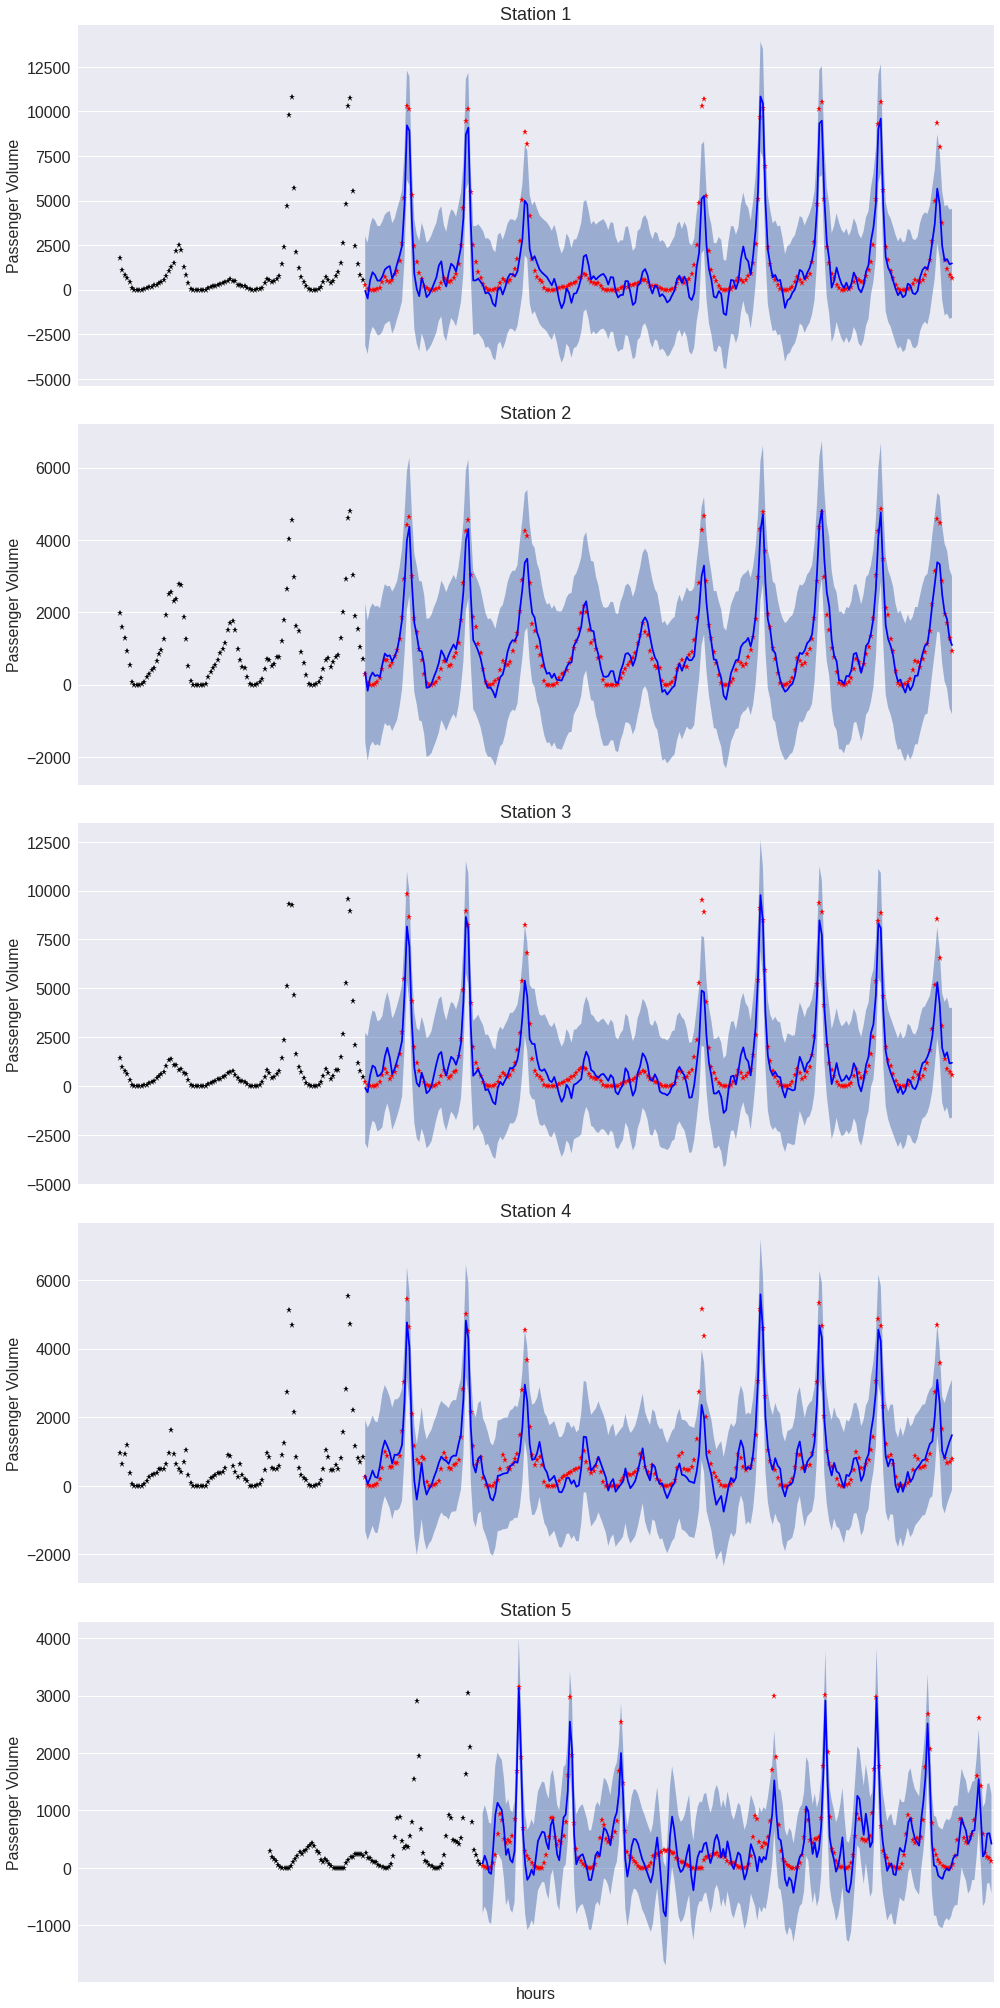

In [ ]:
fig, axes = plt.subplots(5, figsize=(14, 28))
y_train_unscaled = y_scaler.inverse_transform(y_train.T).T
y_valid_unscaled = y_scaler.inverse_transform(y_valid.T).T
for i, ax in enumerate(axes):
    ax = plot_bart(
        ax,
        X_train[i, -100:, 0],
        y_train_unscaled[i, -100:],
        X_valid[i, :, 0],
        y_valid_unscaled[i],
        y_pred[i],
        y_std[i],
    )
    ax.set_title(f"Station {i + 1}", fontsize=18)

ax.set_xlabel('hours', fontsize=16)
plt.xlim([1250, 1680])
plt.tight_layout()

### Retrieving the covariance

If you have worked with sklearn's [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) in the past, you might know that it supports a way to retrieve the covariance by calling `regressor.predict(X, return_cov=True)`. This is not supported by skorch.

It is, however, possible to use the `forward_iter` method to get the covariance indirectly. This will return the posterior distribution, which has a `covariance_matrix` attribute. Below, we show how to use this to plot the covariance of the first 20 data points of the first time series.

In [ ]:
posterior = next(gpr.forward_iter(X_valid))

In [ ]:
posterior

MultivariateNormal(loc: torch.Size([5, 240]))

In [ ]:
posterior.covariance_matrix.shape

torch.Size([5, 240, 240])

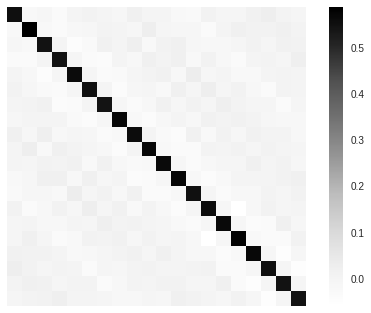

In [ ]:
plt.imshow(posterior.covariance_matrix[0, :20, :20].detach().numpy())
plt.colorbar()
plt.grid(None)
plt.axis('off');

## Stochastic Variational GP Regression

So far, we have dealt with exact GP regression. As the name suggest, this method is exact instead of relying on approximations. There are a few disadvantages, however. Without going into details, exact solutions are in general only possible for Gaussian distributions, so if you want to use another distribution, you cannot use exact GPs. Also, using variational GPs with GPyTorch allows us to use batching, so it allows us to work with larger datasets.

For this part of the notebook, we rely on the following GPyTorch tutorial:

https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html

### Getting the data

Again, we download a real world dataset (if it hasn't been downloaded already) and perform some minor preprocessing first, following the tutorial. Automatic download doesn't work (anymore), so please go to the following URL and then download the file to a `datasets` subfolder within this folder.

https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk

In [ ]:

from scipy.io import loadmat

In [ ]:
path = os.path.join('datasets', 'elevators.mat')

if not os.path.isfile(path):
    raise IOError("Please download the 'elevators.mat' file as described above")

In [ ]:
data = torch.Tensor(loadmat(path)['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# train/valid split
train_n = int(math.floor(0.8 * len(X)))
X_train = X[:train_n, :].contiguous()
y_train = y[:train_n].contiguous()
X_valid = X[train_n:, :].contiguous()
y_valid = y[train_n:].contiguous()

In [ ]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([13279, 18]) torch.Size([13279]) torch.Size([3320, 18]) torch.Size([3320])


As you can see, we deal with a bigger dataset now than before. Thankfully, we will be able to use batching to avoid potential memory issues.

### Defining the module

This time around, since we don't use exact GPs, we actually need to subclass from GPyTorch's `ApproximateGP`. Additionally, we need to define a variational strategy. For more details, please refer to the corresponding [GPyTorch tutorial](https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html).

Apart from that, we have to define the mean function, the kernel function, and the output distribution, as usual.

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [ ]:
class VariationalModule(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Defining the GPRegressor

Since we deal with non-exact GP regression, we import skorch's `GPRegressor`. On top of that, this time around we will see how to obtain validation scores using a predefined split. Specifically, we are interested in the mean absolute error. Fortunately, skorch provides all the tools to make this easy.

In [ ]:
from skorch.probabilistic import GPRegressor
from skorch.callbacks import EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.metrics import mean_absolute_error

First we define the train/validation split using the validation data we split off earlier. Note that the input to `predefined_split` should be a `Dataset`.

In [ ]:
train_split = predefined_split(Dataset(X_valid, y_valid))

Second, we want to calculate the mean absolute error on the validation data, which we can achieve by using skorch's `EpochScoring` and the `mean_absolute_error` metric from sklearn.

In [ ]:
# the "name" argument is only important for printing the output
mae_callback = EpochScoring(mean_absolute_error, name='valid_mae')

Next we initialize the `GPRegressor` using the module, train split, and callback we just defined:

In [ ]:
gpr = GPRegressor(
    VariationalModule,
    module__inducing_points=X_train[:500] if DEVICE == 'cpu' else X_train.cuda()[:500],

    criterion=gpytorch.mlls.VariationalELBO,
    criterion__num_data=int(0.8 * len(y_train)),

    optimizer=torch.optim.Adam,
    lr=0.01,
    batch_size=1024,
    train_split=train_split,
    callbacks=[mae_callback],
    device=DEVICE,
)

Some notes:

- Our variational strategy requires some data as "inducing points", which we pass to the module as `module__inducing_points`. We will use 500 data points from our training data for this.
- We use a criterion to match our variational GP, in this case `VariationalELBO` (the default).
- We can now take advantage of batching by setting `batch_size=1024` instead of -1.
- We set <code>criterion__num_data=int(0.8 * len(y_train))</code>, i.e. to 80% of the total data. This is because above, we split off 20% of the training data for validation. If this number if different (e.g. because you perform a grid search), you should adjust the ratio accordingly.

<div class="alert alert-block alert-warning">
    <b>Warning:</b>
    If you run a grid search, sklearn will split <code>X</code> into several folds, some of which might not contain the samples <code>X[:500]</code>, which can lead to data leakage. In this case, you might want to set aside those inducing points completely, not using them for training at all.
</div>

### Fitting

In [ ]:
gpr.fit(X_train, y_train)

  epoch    train_loss    valid_loss    valid_mae     dur
-------  ------------  ------------  -----------  ------
      1        1.0031        0.8378       0.1155  2.9539
      2        0.7828        0.7296       0.0887  2.7960
      3        0.6923        0.6523       0.0790  2.7925
      4        0.6208        0.5853       0.0765  2.8693
      5        0.5560        0.5218       0.0753  2.9935
      6        0.4932        0.4593       0.0750  4.6813
      7        0.4308        0.3970       0.0751  3.0535
      8        0.3684        0.3345       0.0751  2.8387
      9        0.3058        0.2717       0.0748  2.8133
     10        0.2429        0.2087       0.0746  2.9065


<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=VariationalModule(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

### Analyzing the trained model

As always, we can take a look at the model prediction and the confidence intervals. We only show the first 50 predictions because the time series is really long.

In [ ]:
y_pred, y_std = gpr.predict(X_valid[:50], return_std=True)

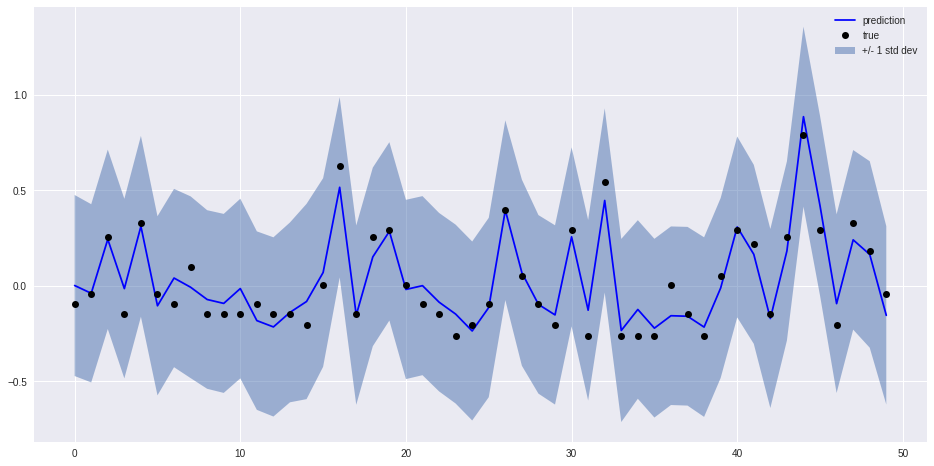

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
x_vec = np.arange(50)
ax.fill_between(x_vec, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.plot(x_vec, y_pred, label='prediction', color='blue')
ax.plot(x_vec, y_valid[:50], 'ko', label='true')
ax.legend();

# Classification

GPs are most frequently used for regression, but it's possible to use them for classification as well. Since the output distribution cannot be a Gaussian in case of classification, we cannot use exact GPs for this. Instead, we again rely on variational GPs.

## Binary classification

For binary classification, we can use skorch's `GPBinaryClassifier`, which uses `gpytorch.likelihoods.BernoulliLikelihood` by default. Bernoulli distributions can be used to model binary outcomes, which is exactly what we're interested in.

This section is loosely based on the following GPyTorch tutorial:

https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html

### Getting the data

Again, we will rely on a toy dataset based on the sine function with added noise for this section. However, instead of defining a regression target, we transform the target into a classification problem by assigning the label 1 to positive targets and 0 to negative targets.

In [ ]:
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + 0.5 * torch.rand(len(X_train)) - 0.25
y_train = (y_train > 0).long()

In [ ]:
X_valid = torch.linspace(-10, 10, 100)
y_valid = (torch.sin(X_valid) > 0).long()

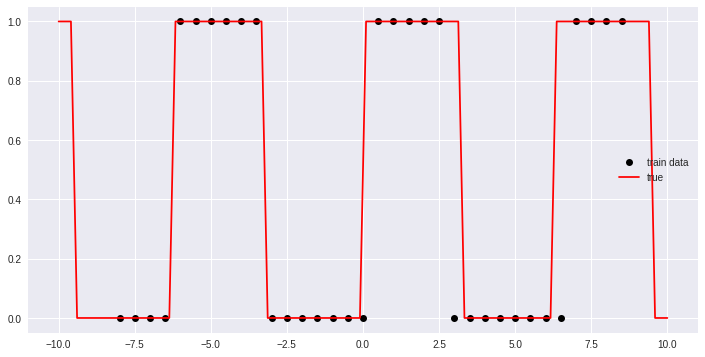

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true')
ax.legend()

### Defining the module

In [ ]:
from gpytorch.variational import UnwhitenedVariationalStrategy

As in the previous example using variational GP, we need to define a variational strategy for our module.

In [ ]:
class GPClassificationModule(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

### Defining the GPBinaryClassifier

In [ ]:
from skorch.probabilistic import GPBinaryClassifier
from sklearn.metrics import accuracy_score

This time around, instead of using skorch's `GPRegressor`, we will use `GPBinaryClassifier`. The rest is pretty much the same as above. As inducing points, we use the whole training dataset, since it's only so small. For bigger datasets, you might want to choose a subset.

In [ ]:
gpc = GPBinaryClassifier(
    GPClassificationModule,
    module__inducing_points=X_train if DEVICE == 'cpu' else X_train.cuda(),
    criterion__num_data=len(X_train),

    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=30,
    device=DEVICE,
)

### Fitting

For classification, `GPBinaryClassifier` performs an internal, stratified train/validation split, as usual for skorch.

In [ ]:
gpc.fit(X_train, y_train)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.5185        0.9305       0.5714        1.3849  0.0276
      2       1.0000        1.9390       0.5714        0.9585  0.0203
      3       1.0000        0.9674       0.5714        0.9877  0.0156
      4       1.0000        1.0619       0.5714        1.1419  0.0155
      5       1.0000        1.3837       0.5714        1.1226  0.0162
      6       1.0000        1.3083       0.5714        1.0169  0.0205
      7       1.0000        1.0615       0.5714        0.9482  0.0182
      8       1.0000        0.9017       0.5714        0.9565  0.0177
      9       1.0000        0.8955       0.5714        1.0097  0.0181
     10       1.0000        0.9748       0.5714        1.0539  0.0163
     11       1.0000        1.0409       0.5714        1.0590  0.0184
     12       1.0000        1.0425       0.5714        1.0293  0.0160
     13       1.0000

<class 'skorch.probabilistic.GPBinaryClassifier'>[initialized](
  module_=GPClassificationModule(
    (variational_strategy): UnwhitenedVariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

### Analyzing the trained model

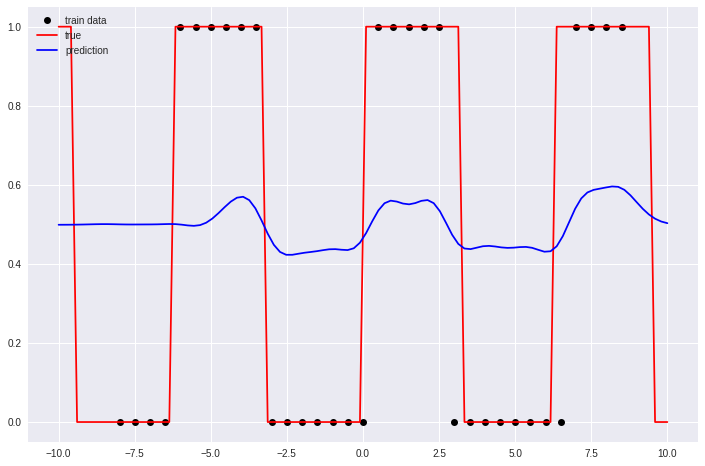

In [ ]:
y_proba = gpc.predict_proba(X_valid)
y_proba = y_proba[:, 1]  # take probability for class=1
y_pred = gpc.predict(X_valid)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true')
ax.plot(X_valid, y_proba, color='blue', label='prediction')
ax.legend()

Here are the accuracy scores and training and validation data:

In [ ]:
accuracy_score(y_train, gpc.predict(X_train))

0.8823529411764706

In [ ]:
accuracy_score(y_valid, gpc.predict(X_valid))

0.78

As you can see, the model performs reasonably on the dataset but the probabilities are not fantastic. Other kinds of models might do better.

## Multiclass Classification

Currently, skorch does not directly support multiclass classification. We can still get there, however, by using sklearn's [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) with `GPBinaryClassifier`.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

### Getting the data

Here we use a synthetic multiclass classification dataset provided by sklearn.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
X, y = make_classification(n_samples=200, n_informative=10, n_classes=5, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

### Defining the model

We use the same module as previously and again define a `GPBinaryClassifier`. We set `verbose=0` to not get flooded by print outputs, and we set `train_split=False` since we're not interested in internal validation scores.

In [ ]:
gpc = GPBinaryClassifier(
    GPClassificationModule,
    # explicit conversion to torch tensor necessary
    module__inducing_points=torch.as_tensor(X_train) if DEVICE == 'cpu' else torch.as_tensor(X_train).cuda(),
    criterion__num_data=len(X_train),

    optimizer=torch.optim.Adam,
    lr=0.05,
    max_epochs=200,
    verbose=0,
    train_split=False,
    device=DEVICE,
)

Next we wrap our binary classifier inside sklearn's `OneVsRestClassifier`.

In [ ]:
clf = OneVsRestClassifier(gpc)

### Fitting

In [ ]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=<class 'skorch.probabilistic.GPBinaryClassifier'>[uninitialized](
  module=<class '__main__.GPClassificationModule'>,
  module__inducing_points=tensor([[-0.4209, -1.8626,  1.7317,  ..., -1.4448, -1.1847,  1.0305],
          [ 2.9429,  2.0599,  5.1854,  ...,  0.3005, -0.5200, -0.8204],
          [-0.2996, -1.3898,  1.9115,  ...,  1.2798,  2.5717,  0.2900],
          ...,
          [ 1.6054, -3.4834,  2.6305,  ..., -0.5219, -0.2894, -0.1725],
          [-1.0977, -0.1791, -1.6726,  ..., -0.9357,  1.5292, -0.0447],
          [ 5.3708, -2.4126, -0.8171,  ...,  0.6439,  0.1507,  1.7870]]),
))

### Analyzing the trained model

Here are the accuracy scores and training and validation data:

In [ ]:
clf.score(X_train, y_train)

0.8266666666666667

In [ ]:
clf.score(X_valid, y_valid)

0.66

The multiclass classifier does quite well on the training data but the score on the validation data leaves something to be desired. Given that we have 5 classes, a naive model would only be 20% accurate, so the given score is markedly better than that, but it's still not spectacular.